In [13]:
import numpy as np
from flask import Flask, request, jsonify, render_template
import pickle
import tensorflow as tf
from tensorflow import keras
import pandas as pd
!pwd
#!pip install flask

'pwd' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
gen_model = tf.keras.models.load_model('generalized_model.h5', compile=False) 
gen_model.summary()

2023-06-01 15:27:31.250481: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 50, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

In [38]:
#test model on input data
#path = '/Users/chitramac/Desktop/archive/'
path = 'us_etf_stocks_dataset\\'
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

def predict_data(model, names, timestep = 50, date = None):
    for name in names:
        scaler = MinMaxScaler()

        data = pd.read_csv(path + f'Stocks\\{name}.us.txt')
        #data = pd.read_csv(path + f'Stocks/{name.lower()}.us.txt')
        if date:
            start_date = data['Date'] >= date
            data = data[start_date]


        data = data['Open']
        data = np.array(data)
        data = data.reshape(-1, 1)
        scaled_data = scaler.fit_transform(data)

        X_test = []
        for i in range(timestep, len(scaled_data)):
            X_test.append(scaled_data[i - timestep:i, 0])
        
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        prediction = model.predict(X_test)
        prediction = scaler.inverse_transform(prediction)

        MSE = mean_squared_error(data[timestep:], prediction)
        R2 = r2_score(data[timestep:], prediction)

        name = name.upper()
        
        plt.plot(data[timestep:], color = 'black', label = f'Actual {name} Stock Price')
        plt.plot(prediction, color = 'green', label = f'Predicted {name} Stock Price')
        plt.title(f'{name} Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.savefig('./static/recent_img.png')
        # plt.show()
        plt.clf()
        return(MSE, R2)


160/160 [==============================] - 3s 20ms/step
MSE: 256.964804121623
R2: 0.9955422338291552


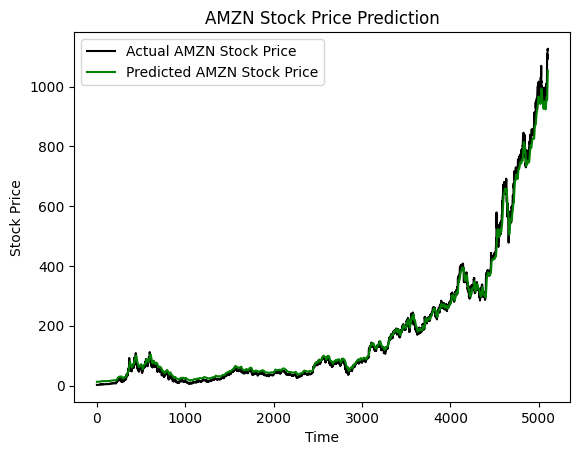

In [15]:
a = predict_data(gen_model, ["AMZN", "NVDA"], timestep = 50, date = None)

In [48]:
app = Flask(__name__)

@app.route('/', methods=['GET'])
def home():
    return render_template("index.html")

@app.route('/', methods=['POST'])
def predict():
    values = list(request.form.values())
    stockfilename = ''.join(values)

    try:
        # check if ticker is in our dataset
        pd.read_csv(path + f'Stocks\\{stockfilename}.us.txt')

        ans = predict_data(gen_model, [stockfilename], timestep=50, date=None)
        return render_template("output.html", data=ans)
    
    except Exception as e:
        # Handle any other exceptions that may occur
        error_msg = "The stock ticker entered is not found. Please try another ticker." 
        print(e)
        return render_template("index.html", error=error_msg)


if __name__ == "__main__":
    app.run(port=2000, debug = False)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:2000
Press CTRL+C to quit
127.0.0.1 - - [01/Jun/2023 17:08:27] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2023 17:08:29] "POST / HTTP/1.1" 200 -


[Errno 2] No such file or directory: 'us_etf_stocks_dataset\\Stocks\\uber.us.txt'


127.0.0.1 - - [01/Jun/2023 17:08:31] "POST / HTTP/1.1" 200 -


[Errno 2] No such file or directory: 'us_etf_stocks_dataset\\Stocks\\lyft.us.txt'
147/147 [==============================] - 3s 20ms/step


127.0.0.1 - - [01/Jun/2023 17:08:38] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2023 17:08:38] "GET /static/recent_img.png HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2023 17:08:42] "GET / HTTP/1.1" 200 -


246/246 [==============================] - 5s 20ms/step


127.0.0.1 - - [01/Jun/2023 17:09:01] "POST / HTTP/1.1" 200 -
127.0.0.1 - - [01/Jun/2023 17:09:01] "GET /static/recent_img.png HTTP/1.1" 200 -


<Figure size 640x480 with 0 Axes>